# Kernel Verification
-----
February 2017.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import clgen
from clgen import dbutil

import json

from labm8 import fs
from labm8 import viz

plt.style.use(["seaborn-white", "seaborn-paper"])

## 1. Experimental Results

Datasets:

In [2]:
!ls -lh ~/data/verify

total 8.5M
-rw-r--r-- 1 cec cec 5.3M Feb 22 17:55 cpu.db
-rw-rw-r-- 1 cec cec  71K Feb 22 17:55 cpu.log
-rw-r--r-- 1 cec cec 3.1M Feb 22 17:55 gpu.db
-rw-rw-r-- 1 cec cec  90K Feb 22 17:55 gpu.log


Load datasets. Set `in1` and `in2` appropriately:

In [3]:
in1 = fs.path("~/data/verify/cpu.db")
in2 = fs.path("~/data/verify/gpu.db")

in1base = fs.basename(in1)
in2base = fs.basename(in2)

db1 = dbutil.connect(in1)
db2 = dbutil.connect(in2)

c1 = db1.cursor()
c2 = db2.cursor()

c1.execute("ATTACH DATABASE '{in2}' AS rhs".format(**vars()))
c2.execute("ATTACH DATABASE '{in1}' AS rhs".format(**vars()))

n1 = dbutil.num_rows_in(in1, "Data")
n2 = dbutil.num_rows_in(in2, "Data")

c1.execute("""
SELECT
    lData.id AS id,
    lData.status AS lstatus, rData.status AS rstatus,
    lData.result AS ldata, rData.result AS rdata
FROM Data AS lData INNER JOIN rhs.Data AS rData ON lData.id=rData.id
WHERE lData.result != "" AND rData.result != ""
""")
cdata = c1.fetchall()

print("Number of results for", in1base, n1)
print("Number of results for", in2base, n2)
print("Number of common good results", len(cdata))

Number of results for cpu.db 1049
Number of results for gpu.db 1395
Number of common good results 7


## 2. Evaluation

### Per-device results

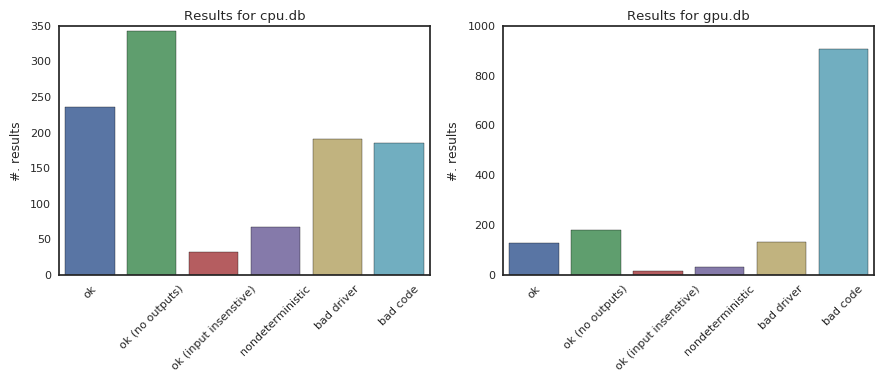

In [8]:
STATUS = ["ok", "ok (no outputs)", "ok (input insenstive)", "nondeterministic", "bad driver", "bad code"]

def plot_dist(path):
    basename = fs.basename(path)
    c = dbutil.connect(path).cursor()
    c.execute("SELECT status, COUNT(status) FROM Data GROUP BY status ORDER BY status")
    d = [{"status": STATUS[i], "n": x} for i, x in c.fetchall()]
    ax = sns.barplot(x="status", y="n", data=pd.DataFrame(d))
    plt.title("Results for {basename}".format(**vars()))
    plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks
    plt.xlabel("")
    plt.ylabel("#. results")

ax = plt.subplot(1, 2, 1)
plot_dist(in1)
ax = plt.subplot(1, 2, 2)
plot_dist(in2)

viz.finalise(figsize=(9, 4))

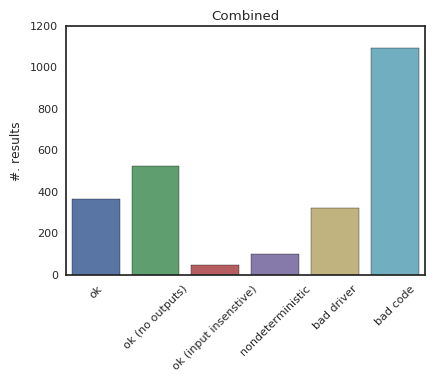

In [9]:
c1.execute("""
SELECT status, COUNT(status) FROM (
    SELECT status FROM Data
    UNION ALL
    SELECT status FROM rhs.Data
) GROUP BY status ORDER BY status
""")
d = [{"status": STATUS[i], "n": x} for i, x in c1.fetchall()]
ax = sns.barplot(x="status", y="n", data=pd.DataFrame(d))
plt.title("Combined")
plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks
plt.xlabel("")
plt.ylabel("#. results")

viz.finalise(figsize=(4.5, 4))

### Different results

In [6]:
from difflib import context_diff, unified_diff
import sys

for row in cdata:
    id, lstatus, rstatus, ldata, rdata = row
    if lstatus != rstatus:
        print("STATUS mismatch", id, lstatus, rstatus)
        
    if ldata != rdata:
        print("DATA mismatch", id)
        ld = json.loads(ldata)
        rd = json.loads(rdata)
        assert(len(ld) == len(rd))  # payloads should have same length
        for i, r in enumerate(zip(ld, rd)):
            a1, a2 = r
            if a1 != a2:
                assert(len(a1) == len(a2))
                
                t1 = ["{}\n".format(x) for x in a1]
                t2 = ["{}\n".format(x) for x in a2]
                diff = list(unified_diff(t1, t2,
                                         fromfile='before.py', tofile='after.py'))
                #print('\n'.join(t))
                print("DIFF OF ARG", i)
                print(''.join(t[:100]))


In [7]:
!cat ~/data/synthetic-2017-02-01/1e7ec8f208eaf040e25f9bae47232c17d9b5892d.cl

__kernel void A(__global float* a, __global float* b, __global float* c, __global float* d, __global float* e) {
  unsigned int f = get_global_id(0);
  int g = get_global_id(1);
  if (f < 128) {
    e[1] += -1;
  }

  barrier(1);
}